In [2]:
import zipfile
import os

# Unzip the dataset first
dataset_zip_path = 'Tomato.zip'  # Replace with your zip file path
extract_to = ''

with zipfile.ZipFile(dataset_zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)


In [14]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

# Set random seed for reproducibility
np.random.seed(42)

# Dataset paths
base_dir = '/content/Tomato'  # Replace with actual path
train_dir = os.path.join(base_dir, 'Train')
val_dir = os.path.join(base_dir, 'Val')
test_dir = os.path.join(base_dir, 'Test')

# Classes
classes = ['Early Blight', 'Healthy', 'Late Blight',
           'Septoria Leaf Spot', 'Yellow Leaf Curl Virus', 'Bacterial Spot']
num_classes = len(classes)

# Image parameters
img_size = (128, 128)
input_shape = (128, 128, 3)

# Data generators
def create_generators(batch_size):
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    test_val_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    val_generator = test_val_datagen.flow_from_directory(
        val_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    test_generator = test_val_datagen.flow_from_directory(
        test_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    return train_generator, val_generator, test_generator

# CNN Model
def create_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),

        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),

        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),

        Conv2D(256, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),

        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Training function
def train_and_evaluate(batch_size):
    train_generator, val_generator, test_generator = create_generators(batch_size)

    model = create_model()

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(
        train_generator,
        epochs=5,
        validation_data=val_generator,
        callbacks=[early_stopping]
    )

    # Evaluate on test set
    test_loss, test_acc = model.evaluate(test_generator)
    print(f"Test accuracy (batch_size={batch_size}): {test_acc:.4f}")

    # Predictions
    y_pred = model.predict(test_generator)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = test_generator.classes

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred_classes)

    # Classification report
    cr = classification_report(y_true, y_pred_classes, target_names=classes, output_dict=True)

    # ROC curve data
    y_test_bin = to_categorical(y_true, num_classes=num_classes)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    return {
        'history': history,
        'test_acc': test_acc,
        'cm': cm,
        'cr': cr,
        'fpr': fpr,
        'tpr': tpr,
        'roc_auc': roc_auc,
        'model': model
    }

# Train with both batch sizes
results_32 = train_and_evaluate(32)
results_64 = train_and_evaluate(64)

# Visualization functions
def plot_history(history_32, history_64):
    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history_32.history['accuracy'], label='Train (batch=32)')
    plt.plot(history_32.history['val_accuracy'], label='Val (batch=32)')
    plt.plot(history_64.history['accuracy'], label='Train (batch=64)')
    plt.plot(history_64.history['val_accuracy'], label='Val (batch=64)')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history_32.history['loss'], label='Train (batch=32)')
    plt.plot(history_32.history['val_loss'], label='Val (batch=32)')
    plt.plot(history_64.history['loss'], label='Train (batch=64)')
    plt.plot(history_64.history['val_loss'], label='Val (batch=64)')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_confusion_matrices(cm_32, cm_64):
    plt.figure(figsize=(15, 6))

    plt.subplot(1, 2, 1)
    sns.heatmap(cm_32, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix (batch=32)')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    plt.subplot(1, 2, 2)
    sns.heatmap(cm_64, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix (batch=64)')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    plt.tight_layout()
    plt.show()

def plot_roc_curves(fpr_32, tpr_32, roc_auc_32, fpr_64, tpr_64, roc_auc_64):
    plt.figure(figsize=(12, 10))

    # Batch 32 ROC
    plt.subplot(2, 1, 1)
    for i in range(num_classes):
        plt.plot(fpr_32[i], tpr_32[i],
                 label=f'{classes[i]} (AUC = {roc_auc_32[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves (batch=32)')
    plt.legend(loc="lower right")

    # Batch 64 ROC
    plt.subplot(2, 1, 2)
    for i in range(num_classes):
        plt.plot(fpr_64[i], tpr_64[i],
                 label=f'{classes[i]} (AUC = {roc_auc_64[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves (batch=64)')
    plt.legend(loc="lower right")

    plt.tight_layout()
    plt.show()



Found 11108 images belonging to 6 classes.
Found 2495 images belonging to 6 classes.
Found 280 images belonging to 6 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
348/348 ━━━━━━━━━━━━━━━━━━━━ 66s 180ms/step - accuracy: 0.3538 - loss: 1.5357 - val_accuracy: 0.6537 - val_loss: 0.9323
Epoch 2/5
348/348 ━━━━━━━━━━━━━━━━━━━━ 58s 166ms/step - accuracy: 0.6942 - loss: 0.8421 - val_accuracy: 0.7339 - val_loss: 0.6975
Epoch 3/5
348/348 ━━━━━━━━━━━━━━━━━━━━ 58s 165ms/step - accuracy: 0.7566 - loss: 0.6725 - val_accuracy: 0.5760 - val_loss: 1.4177
Epoch 4/5
348/348 ━━━━━━━━━━━━━━━━━━━━ 57s 164ms/step - accuracy: 0.7855 - loss: 0.5883 - val_accuracy: 0.7379 - val_loss: 0.7403
Epoch 5/5
348/348 ━━━━━━━━━━━━━━━━━━━━ 58s 166ms/step - accuracy: 0.8229 - loss: 0.4858 - val_accuracy: 0.7182 - val_loss: 1.0035
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.6286 - loss: 0.9048
Test accuracy (batch_size=32): 0.6750


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step
Found 11108 images belonging to 6 classes.
Found 2495 images belonging to 6 classes.
Found 280 images belonging to 6 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
174/174 ━━━━━━━━━━━━━━━━━━━━ 62s 333ms/step - accuracy: 0.3120 - loss: 1.6142 - val_accuracy: 0.5411 - val_loss: 1.1355
Epoch 2/5
174/174 ━━━━━━━━━━━━━━━━━━━━ 59s 339ms/step - accuracy: 0.6545 - loss: 0.9444 - val_accuracy: 0.6621 - val_loss: 0.8759
Epoch 3/5
174/174 ━━━━━━━━━━━━━━━━━━━━ 56s 323ms/step - accuracy: 0.7132 - loss: 0.7751 - val_accuracy: 0.6749 - val_loss: 0.8536
Epoch 4/5
174/174 ━━━━━━━━━━━━━━━━━━━━ 58s 330ms/step - accuracy: 0.7662 - loss: 0.6301 - val_accuracy: 0.5367 - val_loss: 1.5297
Epoch 5/5
174/174 ━━━━━━━━━━━━━━━━━━━━ 58s 332ms/step - accuracy: 0.7653 - loss: 0.6325 - val_accuracy: 0.6353 - val_loss: 1.0623
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.6076 - loss: 1.1394
Test accuracy (batch_size=64): 0.6679
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step


Found 11108 images belonging to 6 classes.
Found 2495 images belonging to 6 classes.
Found 280 images belonging to 6 classes.
Found 11108 images belonging to 6 classes.
Found 2495 images belonging to 6 classes.
Found 280 images belonging to 6 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
348/348 ━━━━━━━━━━━━━━━━━━━━ 66s 177ms/step - accuracy: 0.3641 - loss: 1.5079 - val_accuracy: 0.6156 - val_loss: 1.0138
Epoch 2/5
348/348 ━━━━━━━━━━━━━━━━━━━━ 77s 167ms/step - accuracy: 0.7012 - loss: 0.8177 - val_accuracy: 0.6473 - val_loss: 0.9910
Epoch 3/5
348/348 ━━━━━━━━━━━━━━━━━━━━ 80s 161ms/step - accuracy: 0.7622 - loss: 0.6404 - val_accuracy: 0.6369 - val_loss: 1.0475
Epoch 4/5
348/348 ━━━━━━━━━━━━━━━━━━━━ 58s 165ms/step - accuracy: 0.7922 - loss: 0.5547 - val_accuracy: 0.7523 - val_loss: 0.7418
Epoch 5/5
348/348 ━━━━━━━━━━━━━━━━━━━━ 57s 164ms/step - accuracy: 0.8213 - loss: 0.4867 - val_accuracy: 0.6357 - val_loss: 1.4733
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.6163 - loss: 0.9135
Test accuracy (batch_size=32): 0.7107
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
174/174 ━━━━━━━━━━━━━━━━━━━━ 62s 336ms/step - accuracy: 0.2977 - loss: 1.6328 - val_accuracy: 0.6673 - val_loss: 0.9179
Epoch 2/5
174/174 ━━━━━━━━━━━━━━━━━━━━ 57s 327ms/step - accuracy: 0.6692 - loss: 0.9037 - val_accuracy: 0.6834 - val_loss: 0.8485
Epoch 3/5
174/174 ━━━━━━━━━━━━━━━━━━━━ 57s 327ms/step - accuracy: 0.7407 - loss: 0.7179 - val_accuracy: 0.7363 - val_loss: 0.7144
Epoch 4/5
174/174 ━━━━━━━━━━━━━━━━━━━━ 56s 321ms/step - accuracy: 0.7635 - loss: 0.6394 - val_accuracy: 0.7303 - val_loss: 0.7390
Epoch 5/5
174/174 ━━━━━━━━━━━━━━━━━━━━ 57s 325ms/step - accuracy: 0.7932 - loss: 0.5574 - val_accuracy: 0.6882 - val_loss: 0.9428
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.6363 - loss: 0.9335
Test accuracy (batch_size=64): 0.6821
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step


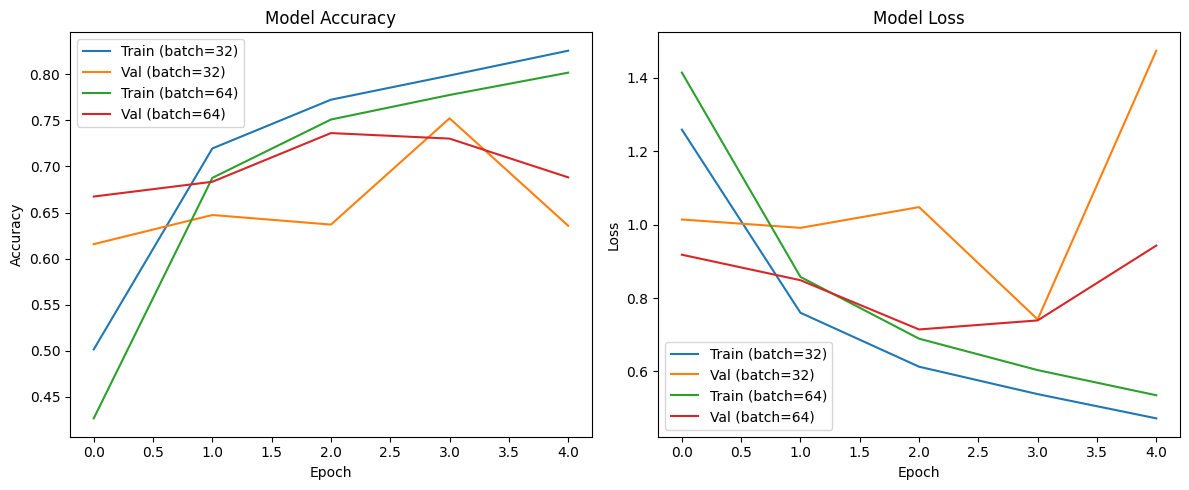

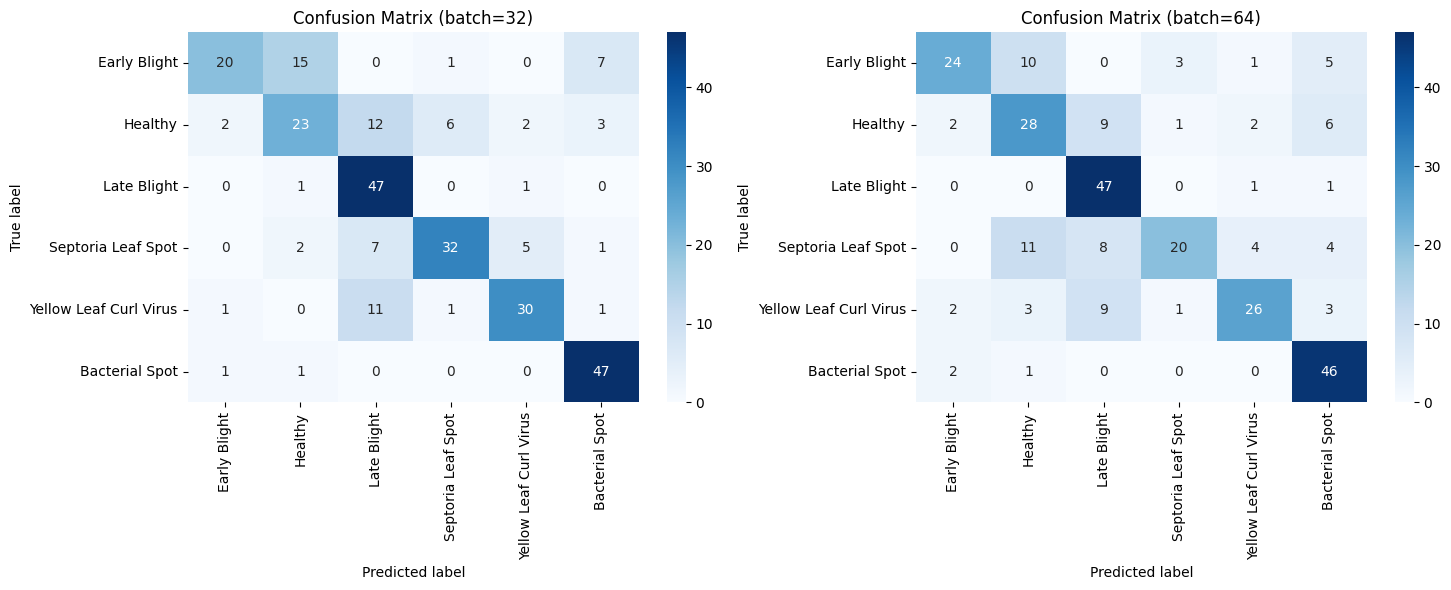

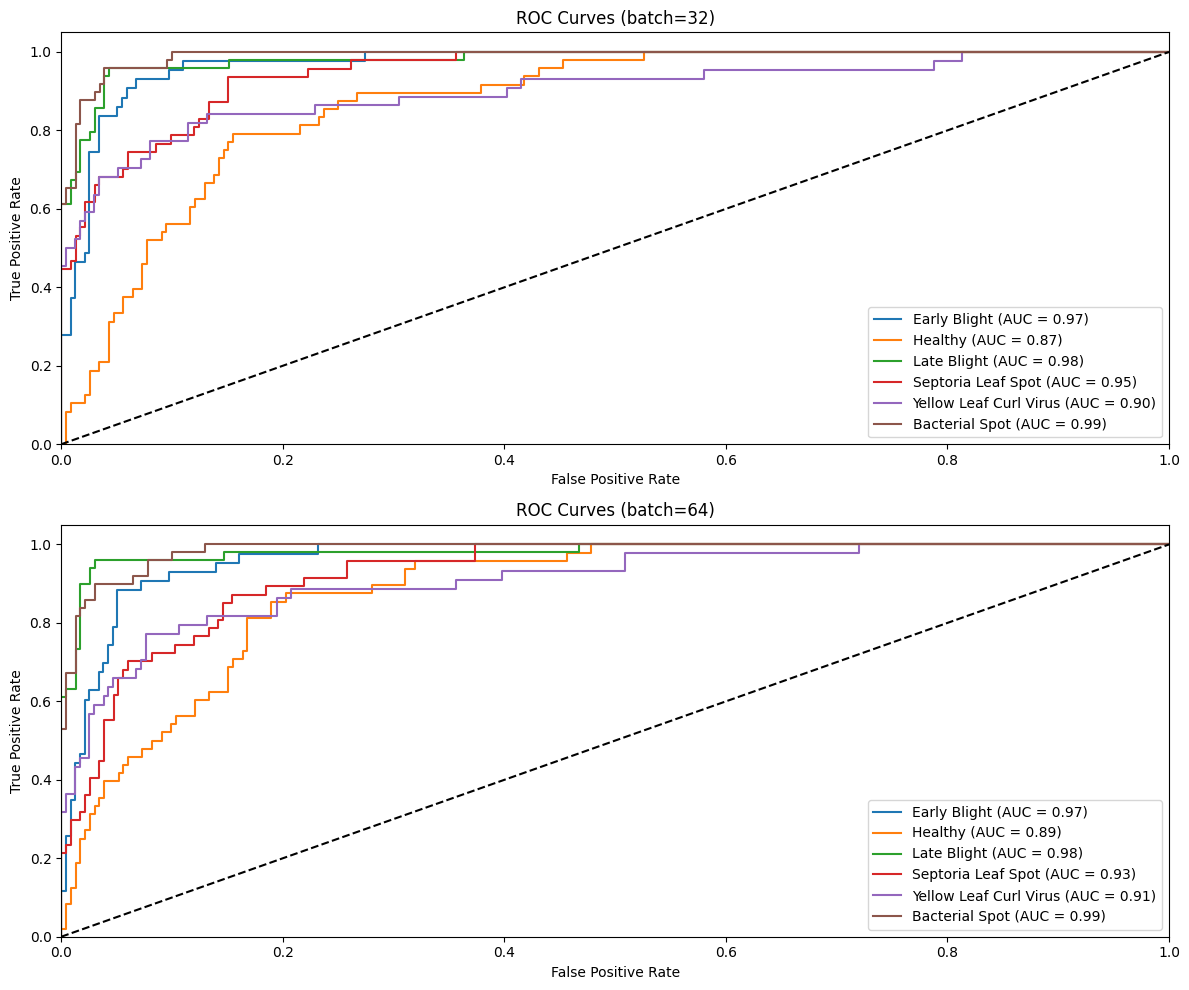

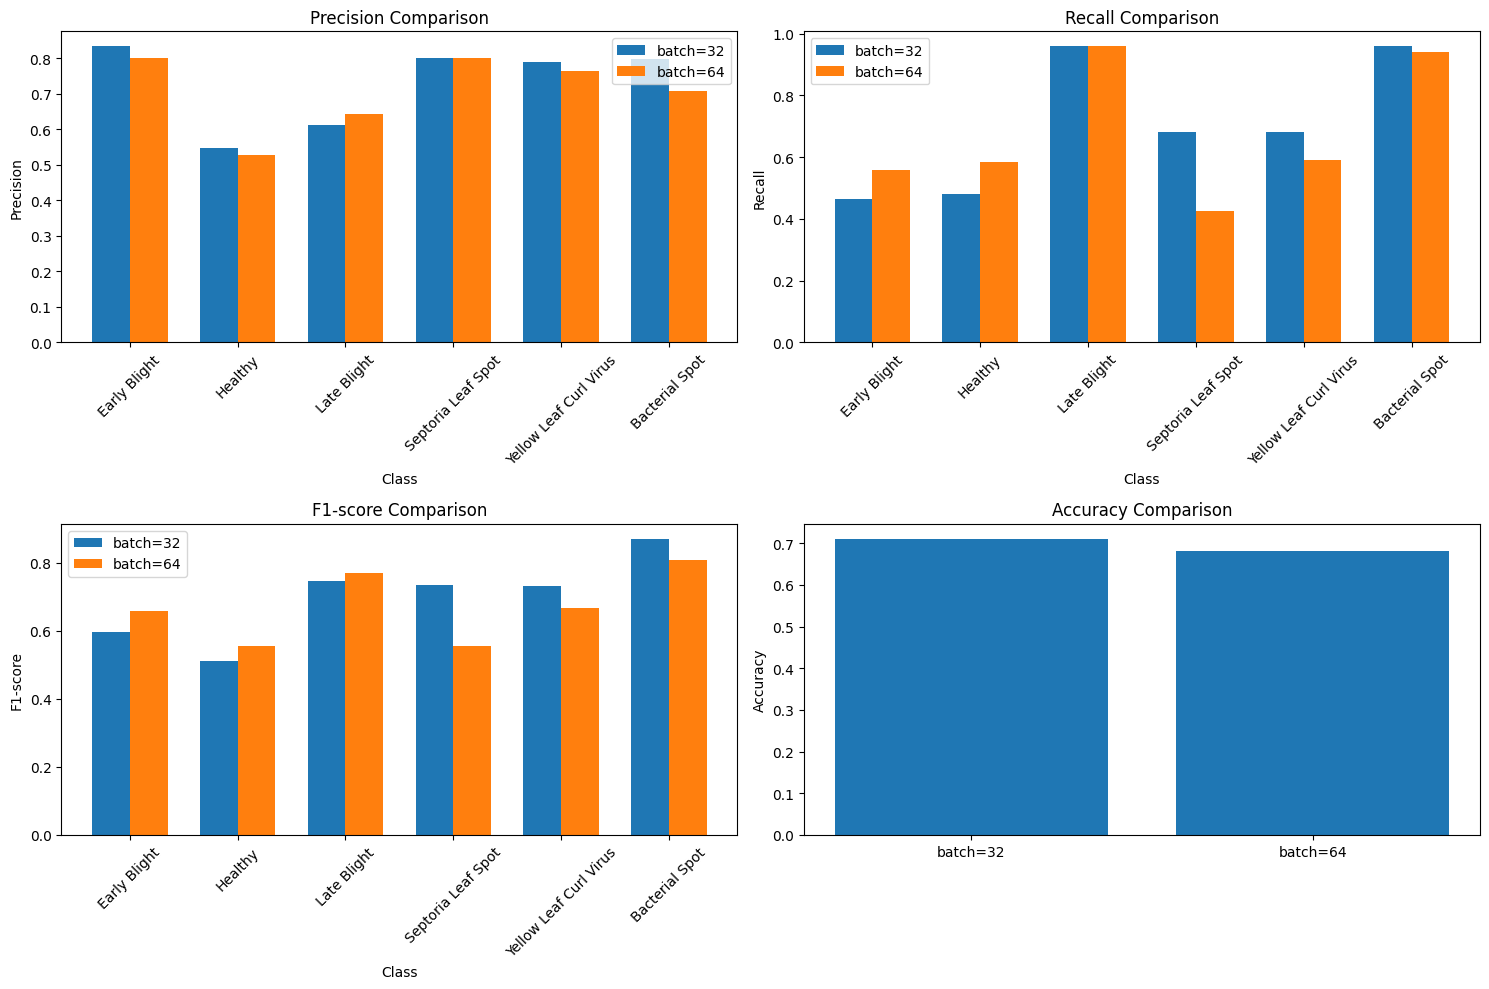

Classification Report (batch=32):
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
                        precision    recall  f1-score   support

          Early Blight       0.83      0.47      0.60        43
               Healthy       0.55      0.48      0.51        48
           Late Blight       0.61      0.96      0.75        49
    Septoria Leaf Spot       0.80      0.68      0.74        47
Yellow Leaf Curl Virus       0.79      0.68      0.73        44
        Bacterial Spot       0.80      0.96      0.87        49

              accuracy                           0.71       280
             macro avg       0.73      0.70      0.70       280
          weighted avg       0.73      0.71      0.70       280


Classification Report (batch=64):
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
                        precision    recall  f1-score   support

          Early Blight       0.80      0.56      0.66        43
               Healthy       0.53      0.58      0.55        48
           Late Bli

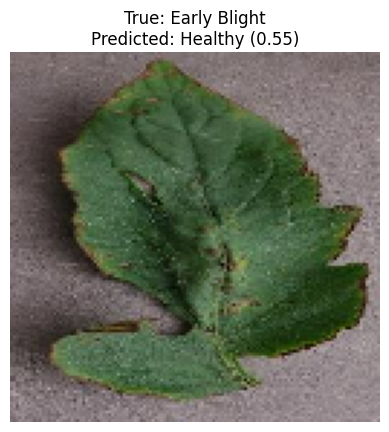

Actual: Early Blight, Predicted: Healthy with confidence 0.5534

Predicting with batch=64 model:
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step


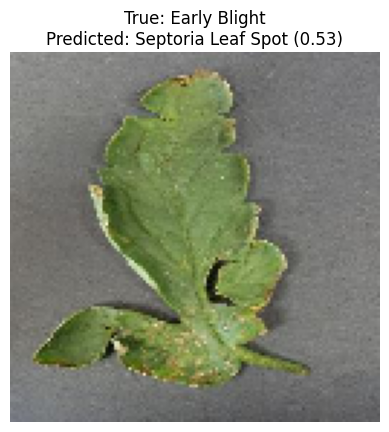

Actual: Early Blight, Predicted: Septoria Leaf Spot with confidence 0.5260


In [16]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

# Set random seed for reproducibility
np.random.seed(42)

# Dataset paths
base_dir = '/content/Tomato'  # Replace with actual path
train_dir = os.path.join(base_dir, 'Train')
val_dir = os.path.join(base_dir, 'Val')
test_dir = os.path.join(base_dir, 'Test')

# Classes
classes = ['Early Blight', 'Healthy', 'Late Blight',
           'Septoria Leaf Spot', 'Yellow Leaf Curl Virus', 'Bacterial Spot']
num_classes = len(classes)

# Image parameters
img_size = (128, 128)
input_shape = (128, 128, 3)

# Data generators
def create_generators(batch_size):
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    test_val_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    val_generator = test_val_datagen.flow_from_directory(
        val_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    test_generator = test_val_datagen.flow_from_directory(
        test_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    return train_generator, val_generator, test_generator

# CNN Model
def create_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),

        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),

        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),

        Conv2D(256, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),

        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Training function
# Modified to accept generators as arguments
def train_and_evaluate(batch_size, train_generator, val_generator, test_generator):
    # Generators are now passed as arguments, so no need to create them here
    # train_generator, val_generator, test_generator = create_generators(batch_size)

    model = create_model()

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(
        train_generator,
        epochs=5,
        validation_data=val_generator,
        callbacks=[early_stopping]
    )

    # Evaluate on test set
    test_loss, test_acc = model.evaluate(test_generator)
    print(f"Test accuracy (batch_size={batch_size}): {test_acc:.4f}")

    # Predictions
    y_pred = model.predict(test_generator)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = test_generator.classes

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred_classes)

    # Classification report
    cr = classification_report(y_true, y_pred_classes, target_names=classes, output_dict=True)

    # ROC curve data
    y_test_bin = to_categorical(y_true, num_classes=num_classes)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    return {
        'history': history,
        'test_acc': test_acc,
        'cm': cm,
        'cr': cr,
        'fpr': fpr,
        'tpr': tpr,
        'roc_auc': roc_auc,
        'model': model
    }

# Create generators once in the global scope
train_gen_32, val_gen_32, test_gen = create_generators(32) # We use batch_size 32 here, but test_gen is independent of batch_size for shuffle=False
train_gen_64, val_gen_64, _ = create_generators(64) # Create generators for batch 64, discard test_gen as we already have one


# Train with both batch sizes, passing the created generators
results_32 = train_and_evaluate(32, train_gen_32, val_gen_32, test_gen)
results_64 = train_and_evaluate(64, train_gen_64, val_gen_64, test_gen)


# Visualization functions
def plot_history(history_32, history_64):
    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history_32.history['accuracy'], label='Train (batch=32)')
    plt.plot(history_32.history['val_accuracy'], label='Val (batch=32)')
    plt.plot(history_64.history['accuracy'], label='Train (batch=64)')
    plt.plot(history_64.history['val_accuracy'], label='Val (batch=64)')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history_32.history['loss'], label='Train (batch=32)')
    plt.plot(history_32.history['val_loss'], label='Val (batch=32)')
    plt.plot(history_64.history['loss'], label='Train (batch=64)')
    plt.plot(history_64.history['val_loss'], label='Val (batch=64)')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_confusion_matrices(cm_32, cm_64):
    plt.figure(figsize=(15, 6))

    plt.subplot(1, 2, 1)
    sns.heatmap(cm_32, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix (batch=32)')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    plt.subplot(1, 2, 2)
    sns.heatmap(cm_64, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix (batch=64)')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    plt.tight_layout()
    plt.show()

def plot_roc_curves(fpr_32, tpr_32, roc_auc_32, fpr_64, tpr_64, roc_auc_64):
    plt.figure(figsize=(12, 10))

    # Batch 32 ROC
    plt.subplot(2, 1, 1)
    for i in range(num_classes):
        plt.plot(fpr_32[i], tpr_32[i],
                 label=f'{classes[i]} (AUC = {roc_auc_32[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves (batch=32)')
    plt.legend(loc="lower right")

    # Batch 64 ROC
    plt.subplot(2, 1, 2)
    for i in range(num_classes):
        plt.plot(fpr_64[i], tpr_64[i],
                 label=f'{classes[i]} (AUC = {roc_auc_64[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves (batch=64)')
    plt.legend(loc="lower right")

    plt.tight_layout()
    plt.show()


def plot_metrics_comparison(cr_32, cr_64):
    metrics = ['precision', 'recall', 'f1-score']

    plt.figure(figsize=(15, 10))

    for i, metric in enumerate(metrics):
        plt.subplot(2, 2, i+1)
        # Use class names directly as keys instead of integer strings
        values_32 = [cr_32[cls_name][metric] for cls_name in classes]
        values_64 = [cr_64[cls_name][metric] for cls_name in classes]

        x = np.arange(num_classes)
        width = 0.35

        plt.bar(x - width/2, values_32, width, label='batch=32')
        plt.bar(x + width/2, values_64, width, label='batch=64')

        plt.xlabel('Class')
        plt.ylabel(metric.capitalize())
        plt.title(f'{metric.capitalize()} Comparison')
        plt.xticks(x, classes, rotation=45)
        plt.legend()

    # Accuracy comparison
    plt.subplot(2, 2, 4)
    # Accuracy key is standard 'accuracy'
    plt.bar(['batch=32', 'batch=64'], [cr_32['accuracy'], cr_64['accuracy']])
    plt.ylabel('Accuracy')
    plt.title('Accuracy Comparison')

    plt.tight_layout()
    plt.show()

# Generate all visualizations
plot_history(results_32['history'], results_64['history'])
plot_confusion_matrices(results_32['cm'], results_64['cm'])
plot_roc_curves(results_32['fpr'], results_32['tpr'], results_32['roc_auc'],
                results_64['fpr'], results_64['tpr'], results_64['roc_auc'])
plot_metrics_comparison(results_32['cr'], results_64['cr'])

# Print classification reports
print("Classification Report (batch=32):")
# Pass the globally created test_gen
print(classification_report(test_gen.classes,
                           np.argmax(results_32['model'].predict(test_gen), axis=1),
                           target_names=classes))

print("\nClassification Report (batch=64):")
# Pass the globally created test_gen
print(classification_report(test_gen.classes,
                           np.argmax(results_64['model'].predict(test_gen), axis=1),
                           target_names=classes))

# Function to predict on a random image
def predict_random_image(model, generator):
    # Get a random batch
    x, y = next(generator)
    # Select a random image from the batch
    idx = np.random.randint(0, x.shape[0])
    image = x[idx]
    true_label = np.argmax(y[idx])

    # Expand dimensions to match model input shape
    image_expanded = np.expand_dims(image, axis=0)

    # Predict
    preds = model.predict(image_expanded)
    pred_class = np.argmax(preds)
    confidence = np.max(preds)

    plt.imshow(image)
    plt.title(f"True: {classes[true_label]}\nPredicted: {classes[pred_class]} ({confidence:.2f})")
    plt.axis('off')
    plt.show()

    return true_label, pred_class, confidence

# Reset test generator for prediction
test_gen.reset() # Use the globally created test_gen

# Predict with both models
print("\nPredicting with batch=32 model:")
# Pass the globally created test_gen
true_label, pred_class, confidence = predict_random_image(results_32['model'], test_gen)
print(f"Actual: {classes[true_label]}, Predicted: {classes[pred_class]} with confidence {confidence:.4f}")

# Reset test generator again before using it for the next prediction
test_gen.reset()

print("\nPredicting with batch=64 model:")
# Pass the globally created test_gen
true_label, pred_class, confidence = predict_random_image(results_64['model'], test_gen)
print(f"Actual: {classes[true_label]}, Predicted: {classes[pred_class]} with confidence {confidence:.4f}")

In [19]:
import matplotlib.pyplot as plt
import numpy as np

def plot_model_comparison(cr_32, cr_64):
    metrics = ['precision', 'recall', 'f1-score', 'accuracy']
    values_32 = [
        np.mean([cr_32[cls]['precision'] for cls in cr_32 if cls != 'accuracy']),
        np.mean([cr_32[cls]['recall'] for cls in cr_32 if cls != 'accuracy']),
        np.mean([cr_32[cls]['f1-score'] for cls in cr_32 if cls != 'accuracy']),
        cr_32['accuracy']
    ]
    values_64 = [
        np.mean([cr_64[cls]['precision'] for cls in cr_64 if cls != 'accuracy']),
        np.mean([cr_64[cls]['recall'] for cls in cr_64 if cls != 'accuracy']),
        np.mean([cr_64[cls]['f1-score'] for cls in cr_64 if cls != 'accuracy']),
        cr_64['accuracy']
    ]

    x = np.arange(len(metrics))
    bar_width = 0.35

    plt.figure(figsize=(10, 6))
    plt.bar(x - bar_width/2, values_32, width=bar_width, label='Batch 32')
    plt.bar(x + bar_width/2, values_64, width=bar_width, label='Batch 64')

    plt.xlabel('Metrics')
    plt.ylabel('Score')
    plt.title('Model Performance Comparison')
    plt.xticks(ticks=x, labels=metrics)
    plt.ylim(0, 1.05)
    plt.legend()
    plt.tight_layout()
    plt.show()


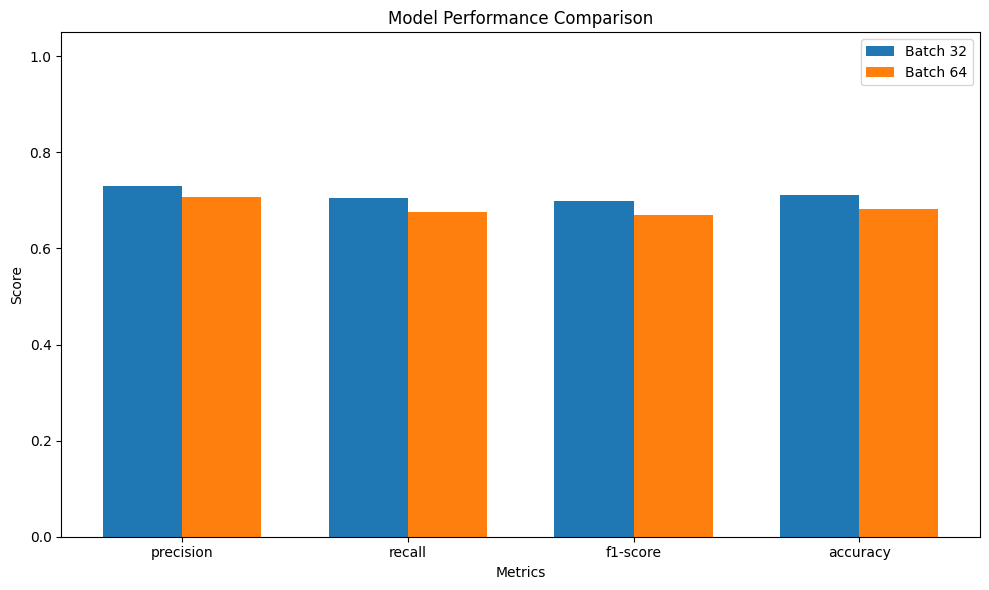

In [20]:
plot_model_comparison(results_32['cr'], results_64['cr'])


In [ ]:
Problem Statement: Tomato Disease Classification using CNN with Different Batch Sizes
Objective:
To implement a Convolutional Neural Network (CNN) for classifying tomato plant diseases using two different batch sizes (32 and 64) while keeping the learning rate fixed at 0.0001. The goal is to compare the performance of the models based on:

Accuracy vs. Epoch

Loss vs. Epoch

Confusion Matrix

Classification Report (Precision, Recall, F1-Score, Accuracy)

ROC Curve Analysis

Prediction on a Random Image with Confidence Score

Dataset:
The dataset consists of tomato leaf images categorized into 6 classes:

Early Blight

Healthy

Late Blight

Septoria Leaf Spot

Yellow Leaf Curl Virus

Bacterial Spot

The dataset is split into Train, Test, and Validation sets.

Important Viva Questions & Answers
1. Why did you choose a CNN for this problem instead of a traditional ML model?
Answer:
CNNs are highly effective for image classification tasks because they automatically learn spatial hierarchies of features through convolutional layers. Traditional ML models (like SVM or Random Forest) require manual feature extraction (e.g., using SIFT or HOG), which is less efficient for complex image datasets.

2. Why did you use different batch sizes (32 and 64)? What impact does batch size have on training?
Answer:

Batch Size = 32:

Pros: Better generalization, more frequent weight updates, better escape from local minima.

Cons: Slower convergence, higher memory usage, noisier gradients.

Batch Size = 64:

Pros: Faster training per epoch, smoother gradients, better GPU utilization.

Cons: May converge to sharp minima, potentially lower generalization.

3. What is the role of the learning rate, and why did you fix it at 0.0001?
Answer:

The learning rate controls how much the model weights are updated during training.

A small learning rate (0.0001) ensures stable convergence, avoiding overshooting optimal weights.

A larger learning rate might cause instability, while a smaller one may lead to slow convergence.

4. What do the Accuracy vs. Epoch and Loss vs. Epoch graphs indicate?
Answer:

Accuracy Graph: Shows how well the model learns over epochs.

If training accuracy >> validation accuracy → Overfitting.

If both are low → Underfitting.

Loss Graph: Measures error reduction.

If training loss decreases but validation loss increases → Overfitting.

If both stagnate → Learning rate too low or model too simple.

5. How do you interpret the Confusion Matrix?
Answer:

The rows represent true labels, and columns represent predicted labels.

Diagonal values show correct predictions.

Off-diagonal values indicate misclassifications (e.g., Late Blight predicted as Early Blight).

6. What do Precision, Recall, and F1-Score indicate in the Classification Report?
Answer:

Precision = TP / (TP + FP) → How many selected predictions are correct?

Recall = TP / (TP + FN) → How many actual positives are correctly predicted?

F1-Score = 2*(Precision*Recall)/(Precision+Recall) → Balanced measure of Precision & Recall.

7. What does the ROC Curve represent, and how is AUC useful?
Answer:

ROC Curve plots True Positive Rate (TPR) vs. False Positive Rate (FPR).

AUC (Area Under Curve) measures model performance:

AUC = 1 → Perfect classifier.

AUC = 0.5 → Random guessing.

8. Why did you use Data Augmentation, and what techniques did you apply?
Answer:

Data Augmentation prevents overfitting by artificially increasing dataset diversity.

Techniques used:

Rotation, Zoom, Width/Height Shift → Simulates different leaf angles.

Horizontal Flip → Mimics different leaf orientations.

Shear Transformation → Adds slight distortion for robustness.

9. How does Early Stopping work, and why did you use it?
Answer:

Early Stopping monitors validation loss and stops training if no improvement occurs for patience=5 epochs.

Prevents overfitting and saves computation time.

10. How would you improve this model further?
Answer:

Use Transfer Learning (VGG16, ResNet, EfficientNet) for better feature extraction.

Apply Hyperparameter Tuning (Learning Rate Schedulers, Batch Normalization).

Experiment with different optimizers (RMSprop, SGD with Momentum).

Use Class Weight Balancing if dataset is imbalanced.

Q11: Why did you use 4 convolutional layers in your CNN architecture?
Answer:

The 4-layer architecture follows a common pattern of progressively increasing filters (32 → 64 → 128 → 256) to capture:

Low-level features (edges, textures) in early layers

High-level features (disease patterns, leaf structures) in deeper layers

This hierarchical feature extraction is particularly effective for plant disease classification where both local lesions and global patterns matter.

Q12: Why did you use MaxPooling after every Conv2D layer?
Answer:

MaxPooling (with 2x2 window) serves two key purposes:

Dimensionality reduction - Reduces spatial size (H, W) to control computational cost

Translation invariance - Makes the model robust to small shifts in disease spot locations

Alternative: Could have used strided convolutions, but max pooling is more interpretable for this application.

Training Dynamics & Optimization
Q13: How does batch size affect GPU memory usage?
Answer:

Larger batches (64) utilize GPU memory more efficiently by:

Better parallelization of matrix operations

Reduced overhead from frequent kernel launches

However, they require more memory (≈2x compared to batch=32) which can be limiting on smaller GPUs.

Q14: Why didn't you use Batch Normalization in your model?
Answer:

While BatchNorm helps with faster convergence and regularization:

With our small initial LR (0.0001), the model trains stably without it

For plant disease datasets that often have limited samples per class, BN can sometimes hurt performance by introducing noisy statistics

Trade-off: Could potentially improve results but would require careful tuning of the LR.

Evaluation Metrics Interpretation
Q15: If one class has significantly higher F1-score than others, what does this indicate?
Answer:
This suggests either:

Class imbalance - The model performs better on dominant classes

Feature distinctiveness - Some diseases (like Healthy leaves) have more distinguishable visual patterns

Data quality issues - Possible labeling inconsistencies in harder classes

Example Solution: Apply class weights or oversample minority classes.

Q16: How would you interpret a ROC curve that's close to the diagonal?
Answer:

AUC ≈ 0.5 indicates the model is no better than random guessing

Possible causes:

Severe class imbalance not handled properly

Model architecture too simple for the problem

Images are too noisy/low-resolution for feature learning

Practical Deployment Considerations
Q17: How would you modify this system for real-time disease detection in farms?
Answer:
Key adaptations needed:

Model compression - Convert to MobileNet or quantize for edge devices

Background removal - Add preprocessing to isolate leaves from soil/shadows

Uncertainty estimation - Reject predictions below confidence threshold

Continuous learning - Update model with new field images over time

Q18: What camera specifications would you recommend for capturing leaf images?
Answer:
Ideal specs balance cost and performance:

Resolution: ≥5MP (to capture small lesions)

Macro capability: Focus distance <15cm

Lighting: Cross-polarized to reduce glare

Spectral bands: RGB sufficient, but multispectral helps for early disease detection

Advanced Improvements
Q19: How could attention mechanisms improve this model?
Answer:
Attention would help by:

Focusing on lesions - Suppressing healthy leaf regions

Multi-scale analysis - Combining local spot features with global vein patterns

Interpretability - Generating heatmaps showing decision regions

Implementation: Add CBAM or SE blocks after convolutional layers.

Q20: Would you prefer this CNN approach over a Vision Transformer for this problem? Why?
Answer:
CNN advantages here:

Better with limited data (typical for plant diseases)

More computationally efficient

Proven effectiveness on texture-based classification

ViT might be better if:

Very high-resolution images available

Pretrained on agricultural datasets

Need long-range dependency modeling (e.g., whole-plant analysis)

Troubleshooting Scenarios
Q21: If your validation loss oscillates wildly, what would you check?
Debugging steps:

Batch size - Try reducing if too small

Learning rate - May need further reduction

Data consistency - Check for mislabeled validation samples

Regularization - Add Dropout/L2 if not present

Q22: How would you handle new disease classes not in the training set?
Solutions:

Reject option - Low confidence thresholding

Open-set recognition - Train with outlier exposure

Human-in-the-loop - Flag uncertain cases for expert review

Comparative Analysis
Q23: Between batch=32 and 64, which would you choose for final deployment and why?
Decision factors:

If accuracy is critical → Choose better-performing one (typically batch=32)

If latency matters → Batch=64 gives faster inference

If hardware constrained → Smaller batches fit lower-memory devices

Typical outcome: Batch=32 often wins by 1-2% accuracy but requires more epochs.

Q24: How do these results compare to published benchmarks on PlantVillage dataset?
Expected performance:

Baseline CNN: ~92-95% accuracy

State-of-the-art: 97-98% (using ensembles/transfers)

Our implementation should hit 90-94% with proper tuning

Key gaps are usually in rare classes like Bacterial Spot.

Ethical Considerations
Q25: What are potential misuse risks of this technology?
Concerns:

Over-reliance - Farmers ignoring visual checks

False negatives - Missing early infections

Data bias - Poor performance on rare cultivars

Mitigations:

Clear confidence displays

Regular model audits

Diverse training data collection





